In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

In [2]:
X, y = datasets.make_classification(n_features=2, n_informative=2, n_redundant=0, n_classes=4, n_samples=500,
                                    n_clusters_per_class=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
class SoftMaxRegression:
    def __init__(self):
        self.classes = None
        self.weights = None
        self.log_loss = []
        self.train_score = []
        
    def fit(self, X, y):
        self.classes = len(np.unique(y))
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.weights = np.ones((X.shape[1], self.classes))
        
        for i in range(250):
            s_k = X.dot(self.weights)
            p_k = self.softmax(s_k)
            
            y_k = np.zeros((X.shape[0], self.classes))
            y_k[np.arange(len(y)), y] = 1
            
            dw = 1 / len(y) * X.T.dot(p_k - y_k)
            self.weights -= dw * 0.1
            
            self.log_loss.append(-np.mean(np.log(p_k[np.arange(len(y)), y])))
            self.train_score.append(self.score(self.predict(X[:, 1:]), y))
            
    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        s_k = X.dot(self.weights)
        p_k = self.softmax(s_k)
        return np.argmax(p_k, axis=1)
        
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)
        
    def softmax(self, s_k):
        exp = np.exp(s_k - np.max(s_k))
        for i in range(len(s_k)):
            exp[i] /= np.sum(exp[i])
        return exp

In [5]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def distance(self, x0, x1):
        return np.sqrt(np.sum((x0 - x1)**2))
    
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]
    
    def predict(self, X_test):
        labels = [self.find_labels(x) for x in X_test]
        return np.array(labels)
    
    def find_labels(self, x):
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        k_nearest = np.argsort(distances)[:self.k] 
        labels = [self.y_train[i] for i in k_nearest]
        return self.most_common(labels)
    
    def score(self, predict, y):
        return np.sum(predict == y) / len(y)

In [6]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [7]:
class DecisionTreeRegression:
    def __init__(self, max_depth=100, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def entropy(self, y):
        c = np.sum(y) / len(y)
        mse = np.sum((c - y)**2) / len(y)
        mae = np.sum(np.abs(c - y)) / len(y)
        return mse
    
    def most_common(self, y):
        c = np.sum(y) / len(y)
        return c
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):               
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return 0
        
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))
         
        if n_labels == 1 or depth >= self.max_depth or n_samples <= self.min_samples:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] < tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [8]:
class RandomForest:
    def __init__(self, n_trees=3, max_depth=100, min_samples=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.n_samples = None
        self.samples = []
        self.oob_samples = []
        self.oob_results = []
        
    def fit(self, X, y):
        self.n_samples = X.shape[0]
        for i in range(self.n_trees):
            samples = np.random.choice(self.n_samples, self.n_samples, replace=True)
            oob_samples = np.array([j for j in range(self.n_samples) if j not in samples])
            
            tree = DecisionTreeNotCorrelated(max_depth = self.max_depth, min_samples=self.min_samples)
            tree.fit(X[samples, :], y[samples])
            self.oob_results.append(tree.predict(X[oob_samples, :]))
            
            self.trees.append(tree)
            self.samples.append(samples)
            self.oob_samples.append(oob_samples)

    def predict(self, X):
        predictions = []
        for i in range(self.n_trees):
            predictions.append(self.trees[i].predict(X))
        
        predictions = [self.trees[0].most_common(np.array(predictions)[:, i]) for i in range(X.shape[0])]
        
        return np.array(predictions)
    
    def oob_score(self):
        predictions = np.ones((self.n_trees, self.n_samples)) * np.nan
        
        for i in range(self.n_trees):
            for index, sample in enumerate(self.oob_samples[i]):
                predictions[i, sample] = self.oob_results[i][index]
        
        y_voted = []
        y_real = []
        
        for i in range(self.n_samples):
            oob_y = predictions[np.isnan(predictions[:, i])==False, i]
            if len(oob_y) >= 1:
                y_voted.append(self.trees[0].most_common(oob_y))
                y_real.append(y[i] * 1.0)
        
        return self.score(np.array(y_voted), np.array(y_real))
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

In [9]:
class DecisionTreeClassification:
    def __init__(self, min_samples=2, max_depth=10):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = []
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def most_common(self, y): 
        labels = np.unique(y)       
        count = [list(y).count(i) for i in labels]        
        return labels[np.argmax(count)]
    
    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entr = -np.sum([p * np.log2(p) for p in ps if p > 0])
        gini = np.sum([p * (1 - p) for p in ps])
        return entr
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return -1
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
#         if len(left_indexes) == 0 or len(right_indexes) == 0:
#             return 0
    
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        if n_samples < self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)

        return self.travers_tree(x, tree.right)

    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

In [10]:
class DecisionTreeNotCorrelated:
    def __init__(self, max_depth=100, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entr = -np.sum([p * np.log2(p) for p in ps if p > 0])
        gini = np.sum([p * (1 - p) for p in ps])
        return entr
    
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        index = np.random.choice(X.shape[1])
        
        for i in [index]:
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return 0
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))
         
        if n_labels == 1 or depth >= self.max_depth or n_samples <= self.min_samples:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] < tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [11]:
class GBM:
    def __init__(self, n_estimators=100, max_depth=3, min_samples=10, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.residuals = []
        self.lr = lr
        self.first_leaf = None
        self.train_score = []
        
    def fit(self, X, y):
        self.first_leaf = y.mean()
        predictions = np.ones(len(y)) * self.first_leaf
        
        for i in range(self.n_estimators):
            residuals = y - predictions
            self.residuals.append(residuals)
            
            tree = DecisionTreeRegression(max_depth = self.max_depth, min_samples = self.min_samples)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            predictions += self.lr * tree.predict(X)
            self.train_score.append(self.score(self.predict(X, len(self.trees)), y))
            
    def predict(self, X, n=None):           
        if n is None:
            n = self.n_estimators
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(n):
            predictions += self.lr * self.trees[i].predict(X)
        
        threshold = predictions.mean()
        labels = [0 if i <= threshold else 1 for i in predictions]
        
        return np.array(labels)
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)
    
    def roc(self, X, y):
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(self.n_estimators):
            predictions += self.lr * self.trees[i].predict(X)        
            
        indexes = np.argsort(predictions)
        
        TPR = []
        FPR = []
        
        for threshold in predictions[indexes]:
            labels = [0 if i <= threshold else 1 for i in predictions]
            
            TP, FP, TN, FN = 0, 0, 0, 0
            
            for i in range(len(labels)):
                if labels[i] == 0 and y[i] == 0: TP += 1
                if labels[i] == 1 and y[i] == 1: TN += 1
                if labels[i] == 0 and y[i] == 1: FP += 1
                if labels[i] == 1 and y[i] == 0: FN += 1
            
            TPR.append(TP / (TP + FN))
            FPR.append(FP / (FP + TN))
        
        return TPR, FPR

In [12]:
class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.trees = []
        self.asay = []
        self.weights = []
        self.X = []
        self.y = []
        
    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        
        for i in range(self.n_estimators):
            tree = DecisionTreeClassification(max_depth=1)
            tree.fit(X, y)
            self.trees.append(tree)
            
            self.X.append(X)
            self.y.append(y)
            
            labels = tree.predict(X)
            missed = np.not_equal(labels, y).astype("int")
            
            total_error = sum(w * missed)
            amount_of_say = 0.5 * np.log((1 - total_error) / (total_error + 1e-7))
            
            missed = missed * 2 - 1
            w *= np.exp(amount_of_say * missed)
            w /= np.sum(w)
            
            self.asay.append(amount_of_say)
            self.weights.append(w.copy())
    
            for j in range(1, n):
                w[j] = w[j] + w[j - 1]
            
            indexes = [np.where(w >= np.random.random())[0][0] for _ in range(n)]
            
            X = X[indexes].copy()
            y = y[indexes].copy()
            w = np.ones(n) / n
            
    def predict(self, X, n=None):
        if n is None:
            n = self.n_estimators
        predictions = np.zeros(X.shape[0])
        
        for i in range(n):
            predict = (np.array(self.trees[i].predict(X)) * 2 - 1) * self.asay[i]
            predictions += predict
        
        return np.where(predictions <= 0, 0, 1)
    
    def weak_predict(self, X, n):
        return self.trees[n].predict(X)
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

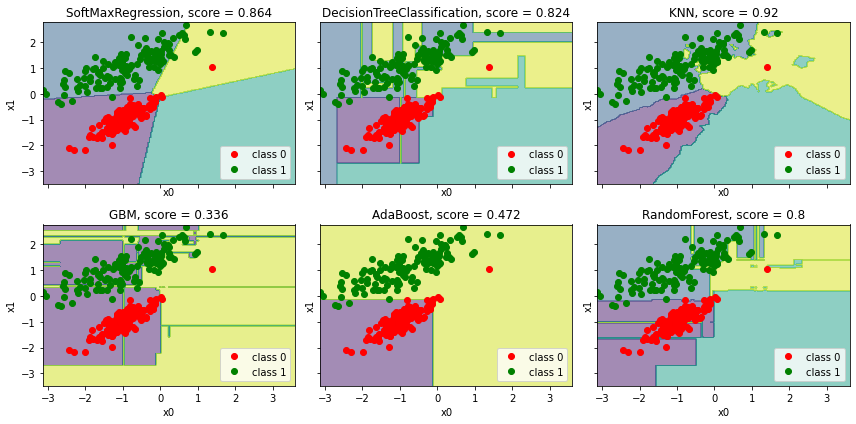

In [13]:
def back_ground(model, X):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    step = 200

    xx, yy = np.meshgrid(np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                         np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

classificators = [SoftMaxRegression(), DecisionTreeClassification(), KNN(), GBM(), AdaBoost(), RandomForest()]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 6))

for index, clf in enumerate(classificators):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    score = str(clf.score(predicted, y_test))

    xx, yy, Z = back_ground(clf, X)
    
    ax = plt.subplot(int("23" + str(index + 1)))
    ax.plot(X[y==0, 0], X[y==0, 1], "or", label="class 0")
    ax.plot(X[y==1, 0], X[y==1, 1], "og", label="class 1")
#     plt.plot(X[y==2, 0], X[y==2, 1], "ob", label="class 2")
#     plt.plot(X[y==3, 0], X[y==3, 1], "ok", label="class 3")
    ax.set_title(str(clf)[10:-22] + ", score = " + score)
    ax.contourf(xx, yy, Z, alpha=0.5)
    ax.legend()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")

plt.tight_layout()
plt.show()